# Exploration and Comparison of Transformers for Image Classification

## Fine-tuning using Vision Transformer (ViT)

Fine-tuning is an experiment that involves training the entire model on the new task. All of model's parameters are end-to-end fine-tuned on the provided dataset.

The resulting model's performance is the measured on the test split with accuracy metric.

### Vision Transformer (ViT)

Vision Transformer (ViT) model pre-trained on ImageNet-21k (14 million images, 21,843 classes) at resolution 224x224, and fine-tuned on ImageNet 2012 (1 million images, 1,000 classes) at resolution 224x224. It was introduced in the paper *An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale by Dosovitskiy et al.*

https://arxiv.org/abs/2010.11929

### Prerequisites

Load necessary packages.

In [2]:
import os
os.chdir('..')

import torch

import pandas as pd

from datasets import load_dataset

from src.dataset_builder import ImageDataset
from src.models import *
from src.train import *

from utils.config import Config
from utils.train_utils import *
from utils.models_utils import *
from utils.visualization_utils import *
from utils.data_utils import *

Check if there is GPU available.

In [3]:
get_gpu_info()

GPU 0: NVIDIA A100 80GB PCIe MIG 2g.20gb
VRAM: 19.50 GB


Set manual seed for reproducibility.

In [4]:
id = 10
torch.manual_seed(10)

Load ViT image processor used for image pre-processing.

In [5]:
processor = get_backbone_processor(model_names['ViT'])

Print the pre-processing operations done by the processor.

In [6]:
processor

ViTImageProcessorFast {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessorFast",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

### Data Preprocessing

Load each dataset and its splits.

Processor is automatically applied to each image.

#### RESISC45

In [8]:
resisc45 = load_dataset('timm/resisc45')
clean_labels(resisc45, name='resisc45')
resisc45_train = ImageDataset(
    dataset=resisc45['train'],
    processor=processor,
)
resisc45_validation = ImageDataset(
    dataset=resisc45['validation'],
    processor=processor,
)
resisc45_test = ImageDataset(
    dataset=resisc45['test'],
    processor=processor,
)

#### Food-101

In [10]:
food101 = load_dataset('ethz/food101')
clean_labels(food101, name='food101')
food101_train = ImageDataset(
    dataset=food101['train'],
    processor=processor,
)
food101_validation = ImageDataset(
    dataset=food101['validation'],
    processor=processor,
)

#### FER2013

In [12]:
fer2013 = load_dataset('AutumnQiu/fer2013')
clean_labels(fer2013, name='fer2013')
fer2013_train = ImageDataset(
    dataset=fer2013['train'],
    processor=processor,
)
fer2013_validation = ImageDataset(
    dataset=fer2013['valid'],
    processor=processor,
)
fer2013_test = ImageDataset(
    dataset=fer2013['test'],
    processor=processor,
)

#### PCam

In [14]:
pcam = load_dataset('zacharielegault/PatchCamelyon')
clean_labels(pcam, name='pcam')
pcam_train = ImageDataset(
    dataset=pcam['train'],
    processor=processor,
)
pcam_validation = ImageDataset(
    dataset=pcam['validation'],
    processor=processor,
)
pcam_test = ImageDataset(
    dataset=pcam['test'],
    processor=processor,
)

#### SUN397

In [16]:
sun397 = load_dataset('dpdl-benchmark/sun397')
clean_labels(sun397, name='sun397')
sun397_train = ImageDataset(
    dataset=sun397['train'],
    processor=processor,
)
sun397_validation = ImageDataset(
    dataset=sun397['validation'],
    processor=processor,
)
sun397_test = ImageDataset(
    dataset=sun397['test'],
    processor=processor,
)

#### DTD

In [18]:
dtd = load_dataset('tanganke/dtd')
clean_labels(dtd, name='dtd')
dtd_train = ImageDataset(
    dataset=dtd['train'],
    processor=processor,
)
dtd_test = ImageDataset(
    dataset=dtd['test'],
    processor=processor,
)

### Config

Create a config for experiments and print its settings.

In [19]:
from torch.optim import AdamW

config = Config(
    num_epochs=10, 
    lr=2e-5,
    optimizer=AdamW,
    weight_decay=1e-2
)
config.get_settings()

{'device': 'cuda',
 'criterion': CrossEntropyLoss(),
 'batch_size': 8,
 'lr': 2e-05,
 'num_epochs': 10,
 'optimizer': torch.optim.adamw.AdamW,
 'weight_decay': 0.01}

Create empty array to store dataset accuracies for each experiment.

In [20]:
resisc45_accs = []
food101_accs = []
fer2013_accs = []
pcam_accs = []
sun397_accs = []
dtd_accs = []

### Fine-tuning


Train the entire model and all of its parameters on a new dataset.

#### RESISC45

In [21]:
vit_resisc45 = Backbone(model_names['ViT'], num_classes=len(resisc45_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([45]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([45, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
get_model_params(vit_resisc45)

Parameters: 85.83M


In [23]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = train_model(
    vit_resisc45,
    resisc45_train,
    config,
    'vit',
    use_val=False,
    fine_tune=True,
)

100%|██████████| 2363/2363 [03:16<00:00, 12.03it/s]


Epochs: 1/10 | train_loss: 0.7344 | train_acc: 0.8369


100%|██████████| 2363/2363 [03:13<00:00, 12.22it/s]


Epochs: 2/10 | train_loss: 0.1138 | train_acc: 0.9690


100%|██████████| 2363/2363 [03:12<00:00, 12.27it/s]


Epochs: 3/10 | train_loss: 0.0440 | train_acc: 0.9886


100%|██████████| 2363/2363 [03:12<00:00, 12.27it/s]


Epochs: 4/10 | train_loss: 0.0250 | train_acc: 0.9935


100%|██████████| 2363/2363 [03:12<00:00, 12.30it/s]


Epochs: 5/10 | train_loss: 0.0201 | train_acc: 0.9947


100%|██████████| 2363/2363 [03:12<00:00, 12.27it/s]


Epochs: 6/10 | train_loss: 0.0184 | train_acc: 0.9946


100%|██████████| 2363/2363 [03:12<00:00, 12.28it/s]


Epochs: 7/10 | train_loss: 0.0154 | train_acc: 0.9961


100%|██████████| 2363/2363 [03:12<00:00, 12.28it/s]


Epochs: 8/10 | train_loss: 0.0145 | train_acc: 0.9960


100%|██████████| 2363/2363 [03:11<00:00, 12.31it/s]


Epochs: 9/10 | train_loss: 0.0135 | train_acc: 0.9964


100%|██████████| 2363/2363 [03:12<00:00, 12.25it/s]

Epochs: 10/10 | train_loss: 0.0150 | train_acc: 0.9961


In [24]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = evaluate_model(
    vit_resisc45,
    resisc45_test,
    config
)

100%|██████████| 788/788 [00:23<00:00, 33.74it/s]

test_loss: 0.2228 | test_acc: 0.9460


In [25]:
resisc45_accs.append(resisc45_acc)

In [26]:
get_top_5_accuracies(resisc45_per_class_acc)

[('harbor', 1.0),
 ('airplane', 0.9940828402366864),
 ('cloud', 0.9937106918238994),
 ('snowberg', 0.9937106918238994),
 ('sea ice', 0.9933774834437086)]

In [27]:
get_bottom_5_accuracies(resisc45_per_class_acc)

[('commercial area', 0.8214285714285714),
 ('palace', 0.8285714285714286),
 ('wetland', 0.8305084745762712),
 ('railway station', 0.8376623376623377),
 ('medium residential', 0.8503401360544217)]

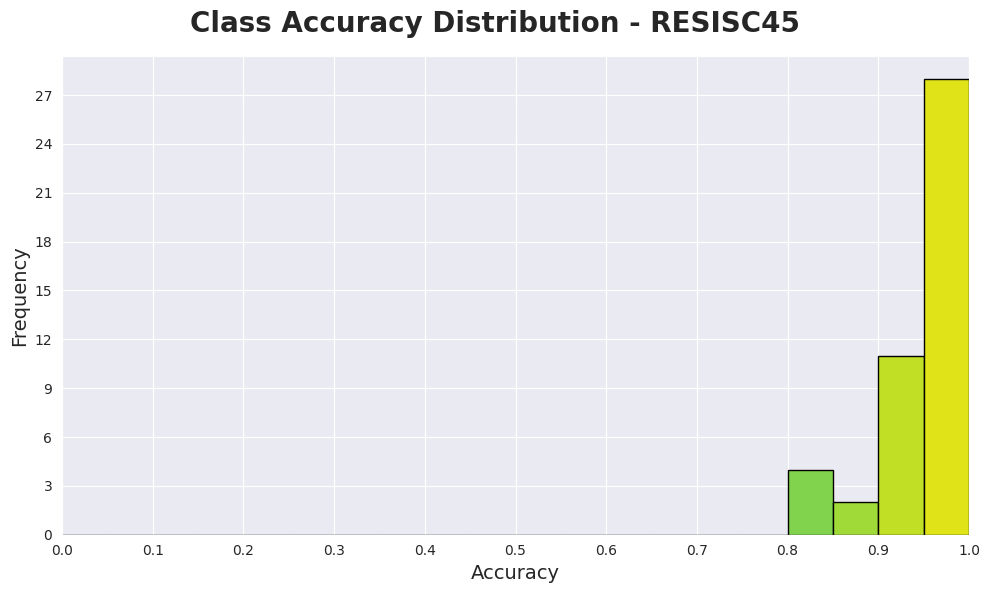

In [28]:
plot_per_class_accuracies(
    resisc45_per_class_acc,
    'RESISC45',
    num_bins=20
)

#### Food-101

In [29]:
vit_food101 = Backbone(model_names['ViT'], num_classes=len(food101_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
get_model_params(vit_food101)

Parameters: 85.88M


In [31]:
food101_loss, food101_acc, food101_per_class_acc = train_model(
    vit_food101,
    food101_train,
    config,
    'vit',
    use_val=False,
    fine_tune=True,
)

  5%|▌         | 503/9469 [00:53<15:18,  9.77it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 9469/9469 [15:10<00:00, 10.40it/s]


Epochs: 1/10 | train_loss: 1.0582 | train_acc: 0.7653


100%|██████████| 9469/9469 [14:55<00:00, 10.58it/s]


Epochs: 2/10 | train_loss: 0.3554 | train_acc: 0.9081


100%|██████████| 9469/9469 [14:55<00:00, 10.58it/s]


Epochs: 3/10 | train_loss: 0.1626 | train_acc: 0.9595


100%|██████████| 9469/9469 [14:57<00:00, 10.55it/s]


Epochs: 4/10 | train_loss: 0.0829 | train_acc: 0.9796


100%|██████████| 9469/9469 [14:53<00:00, 10.60it/s]


Epochs: 5/10 | train_loss: 0.0525 | train_acc: 0.9861


100%|██████████| 9469/9469 [14:56<00:00, 10.56it/s]


Epochs: 6/10 | train_loss: 0.0415 | train_acc: 0.9889


100%|██████████| 9469/9469 [14:55<00:00, 10.57it/s]


Epochs: 7/10 | train_loss: 0.0346 | train_acc: 0.9902


100%|██████████| 9469/9469 [14:56<00:00, 10.56it/s]


Epochs: 8/10 | train_loss: 0.0324 | train_acc: 0.9907


100%|██████████| 9469/9469 [14:54<00:00, 10.58it/s]


Epochs: 9/10 | train_loss: 0.0307 | train_acc: 0.9910


100%|██████████| 9469/9469 [14:56<00:00, 10.56it/s]


Epochs: 10/10 | train_loss: 0.0300 | train_acc: 0.9911


In [32]:
food101_loss, food101_acc, food101_per_class_acc = evaluate_model(
    vit_food101,
    food101_validation,
    config
)

100%|██████████| 3157/3157 [02:11<00:00, 24.05it/s]


test_loss: 0.5987 | test_acc: 0.8779


In [33]:
food101_accs.append(food101_acc)

In [34]:
get_top_5_accuracies(food101_per_class_acc)

[('edamame', 0.996),
 ('spaghetti carbonara', 0.98),
 ('macarons', 0.976),
 ('oysters', 0.976),
 ('pho', 0.968)]

In [35]:
get_bottom_5_accuracies(food101_per_class_acc)

[('steak', 0.512),
 ('filet mignon', 0.696),
 ('cheesecake', 0.708),
 ('breakfast burrito', 0.716),
 ('apple pie', 0.72)]

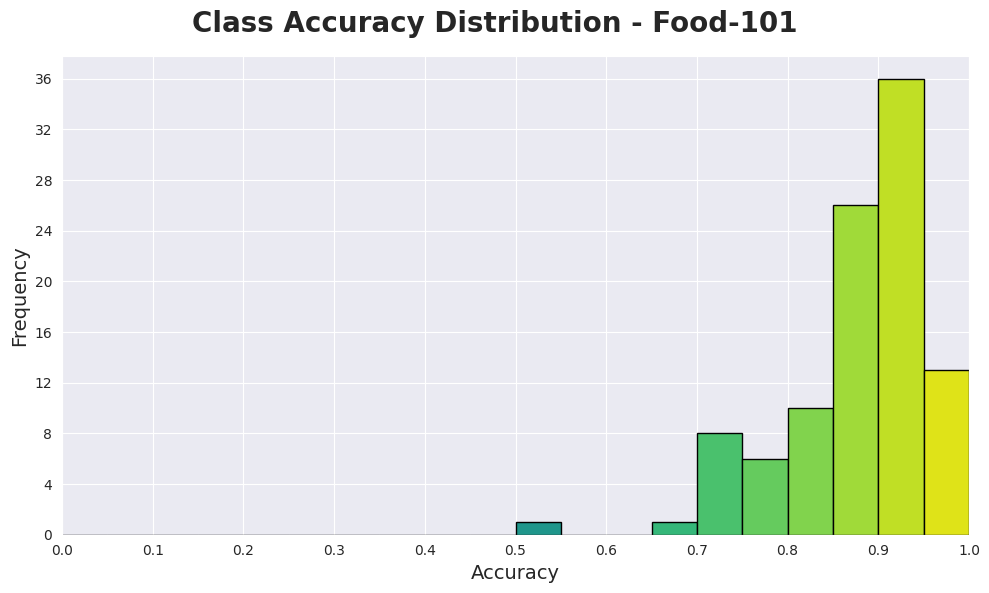

In [36]:
plot_per_class_accuracies(
    food101_per_class_acc,
    'Food-101',
    num_bins=20
)

#### FER2013

In [37]:
vit_fer2013 = Backbone(model_names['ViT'], num_classes=len(fer2013_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
get_model_params(vit_fer2013)

Parameters: 85.80M


In [40]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = train_model(
    vit_fer2013,
    fer2013_train,
    config,
    'vit',
    use_val=False,
    fine_tune=True,
)

100%|██████████| 3589/3589 [04:37<00:00, 12.95it/s]


Epochs: 1/10 | train_loss: 1.0017 | train_acc: 0.6252


100%|██████████| 3589/3589 [04:36<00:00, 13.00it/s]


Epochs: 2/10 | train_loss: 0.7084 | train_acc: 0.7416


100%|██████████| 3589/3589 [04:36<00:00, 13.00it/s]


Epochs: 3/10 | train_loss: 0.4589 | train_acc: 0.8407


100%|██████████| 3589/3589 [04:36<00:00, 13.00it/s]


Epochs: 4/10 | train_loss: 0.2383 | train_acc: 0.9226


100%|██████████| 3589/3589 [04:36<00:00, 13.00it/s]


Epochs: 5/10 | train_loss: 0.1199 | train_acc: 0.9631


100%|██████████| 3589/3589 [04:36<00:00, 12.99it/s]


Epochs: 6/10 | train_loss: 0.0816 | train_acc: 0.9751


100%|██████████| 3589/3589 [04:36<00:00, 12.96it/s]


Epochs: 7/10 | train_loss: 0.0670 | train_acc: 0.9797


100%|██████████| 3589/3589 [04:36<00:00, 12.99it/s]


Epochs: 8/10 | train_loss: 0.0596 | train_acc: 0.9812


100%|██████████| 3589/3589 [04:36<00:00, 12.99it/s]


Epochs: 9/10 | train_loss: 0.0553 | train_acc: 0.9816


100%|██████████| 3589/3589 [04:36<00:00, 12.99it/s]

Epochs: 10/10 | train_loss: 0.0505 | train_acc: 0.9844


In [41]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = evaluate_model(
    vit_fer2013,
    fer2013_test,
    config
)

100%|██████████| 449/449 [00:11<00:00, 40.37it/s]

test_loss: 1.5437 | test_acc: 0.6977


In [42]:
fer2013_accs.append(fer2013_acc)

In [43]:
fer2013_per_class_acc

{'angry': 0.6456211812627292,
 'disgust': 0.7272727272727273,
 'fear': 0.5492424242424242,
 'happy': 0.9078498293515358,
 'sad': 0.6094276094276094,
 'surprise': 0.7644230769230769,
 'neutral': 0.6054313099041534}

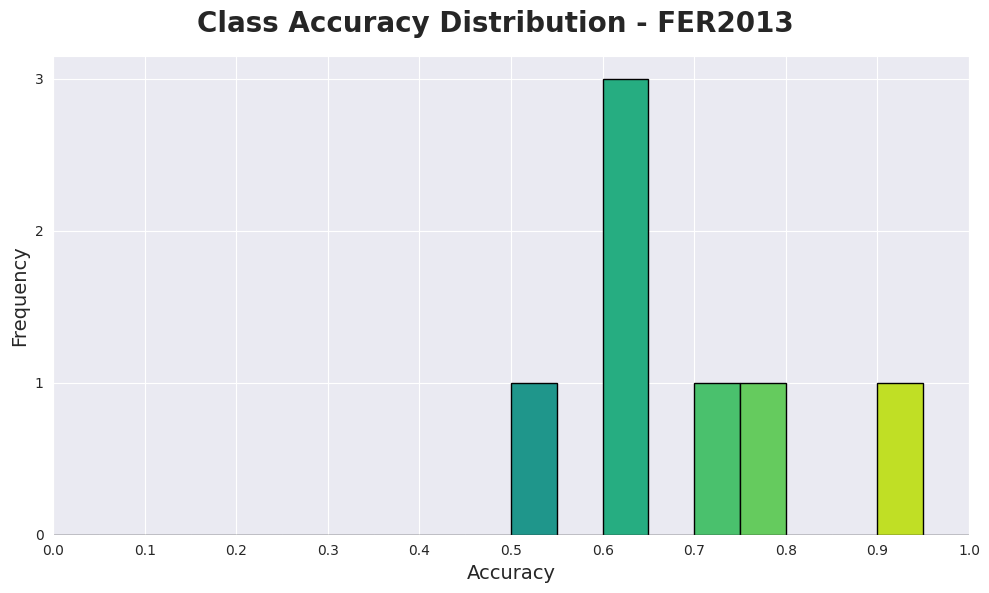

In [44]:
plot_per_class_accuracies(
    fer2013_per_class_acc,
    'FER2013',
    num_bins=20
)

#### PCam

In [45]:
vit_pcam = Backbone(model_names['ViT'], num_classes=len(pcam_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
get_model_params(vit_pcam)

Parameters: 85.80M


In [47]:
pcam_loss, pcam_acc, pcam_per_class_acc = train_model(
    vit_pcam,
    pcam_train,
    config,
    'vit',
    use_val=False,
    fine_tune=True,
)

100%|██████████| 32768/32768 [43:28<00:00, 12.56it/s]


Epochs: 1/10 | train_loss: 0.1114 | train_acc: 0.9599


100%|██████████| 32768/32768 [43:30<00:00, 12.55it/s]


Epochs: 2/10 | train_loss: 0.0547 | train_acc: 0.9816


100%|██████████| 32768/32768 [43:36<00:00, 12.52it/s]


Epochs: 3/10 | train_loss: 0.0331 | train_acc: 0.9889


100%|██████████| 32768/32768 [43:58<00:00, 12.42it/s]


Epochs: 4/10 | train_loss: 0.0225 | train_acc: 0.9923


100%|██████████| 32768/32768 [43:50<00:00, 12.45it/s]


Epochs: 5/10 | train_loss: 0.0176 | train_acc: 0.9940


100%|██████████| 32768/32768 [43:35<00:00, 12.53it/s]


Epochs: 6/10 | train_loss: 0.0148 | train_acc: 0.9951


100%|██████████| 32768/32768 [43:44<00:00, 12.49it/s]


Epochs: 7/10 | train_loss: 0.0129 | train_acc: 0.9957


100%|██████████| 32768/32768 [43:40<00:00, 12.51it/s]


Epochs: 8/10 | train_loss: 0.0119 | train_acc: 0.9961


100%|██████████| 32768/32768 [43:29<00:00, 12.56it/s]


Epochs: 9/10 | train_loss: 0.0113 | train_acc: 0.9964


100%|██████████| 32768/32768 [43:23<00:00, 12.59it/s]


Epochs: 10/10 | train_loss: 0.0104 | train_acc: 0.9965


In [48]:
pcam_loss, pcam_acc, pcam_per_class_acc = evaluate_model(
    vit_pcam,
    pcam_test,
    config
)

100%|██████████| 4096/4096 [01:48<00:00, 37.75it/s]

test_loss: 0.6349 | test_acc: 0.8887


In [49]:
pcam_accs.append(pcam_acc)

In [50]:
pcam_per_class_acc

{'healthy lymph node tissue': 0.9744371911414801,
 'lymph node tumor tissue': 0.8028943029858948}

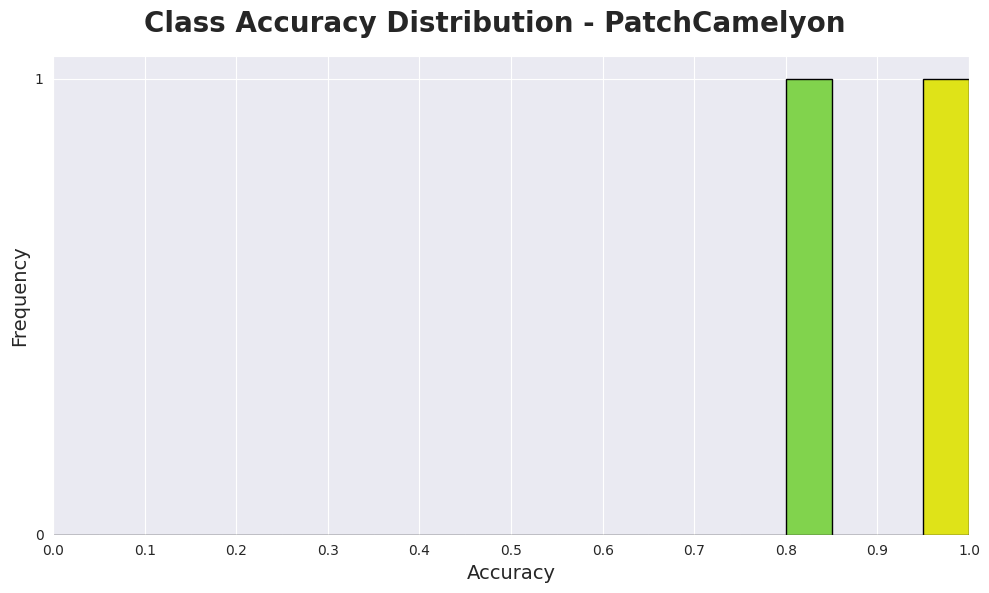

In [51]:
plot_per_class_accuracies(
    pcam_per_class_acc,
    'PatchCamelyon',
    num_bins=20
)

#### SUN397

In [52]:
vit_sun397 = Backbone(model_names['ViT'], num_classes=len(sun397_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([397]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([397, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
get_model_params(vit_sun397)

Parameters: 86.10M


In [54]:
sun397_loss, sun397_acc, sun397_per_class_acc = train_model(
    vit_sun397,
    sun397_train,
    config,
    'vit',
    use_val=False,
    fine_tune=True,
)

100%|██████████| 9516/9516 [17:38<00:00,  8.99it/s]


Epochs: 1/10 | train_loss: 1.8764 | train_acc: 0.6264


100%|██████████| 9516/9516 [16:14<00:00,  9.77it/s]


Epochs: 2/10 | train_loss: 0.6001 | train_acc: 0.8353


100%|██████████| 9516/9516 [16:21<00:00,  9.69it/s]


Epochs: 3/10 | train_loss: 0.3093 | train_acc: 0.9125


100%|██████████| 9516/9516 [16:13<00:00,  9.77it/s]


Epochs: 4/10 | train_loss: 0.1541 | train_acc: 0.9585


100%|██████████| 9516/9516 [16:13<00:00,  9.78it/s]


Epochs: 5/10 | train_loss: 0.0813 | train_acc: 0.9795


100%|██████████| 9516/9516 [16:15<00:00,  9.75it/s]


Epochs: 6/10 | train_loss: 0.0582 | train_acc: 0.9845


100%|██████████| 9516/9516 [16:26<00:00,  9.64it/s]


Epochs: 7/10 | train_loss: 0.0418 | train_acc: 0.9893


100%|██████████| 9516/9516 [16:22<00:00,  9.69it/s]


Epochs: 8/10 | train_loss: 0.0412 | train_acc: 0.9884


100%|██████████| 9516/9516 [16:07<00:00,  9.84it/s]


Epochs: 9/10 | train_loss: 0.0349 | train_acc: 0.9905


100%|██████████| 9516/9516 [16:06<00:00,  9.85it/s]


Epochs: 10/10 | train_loss: 0.0328 | train_acc: 0.9907


In [55]:
sun397_loss, sun397_acc, sun397_per_class_acc = evaluate_model(
    vit_sun397,
    sun397_test,
    config
)

100%|██████████| 2719/2719 [02:19<00:00, 19.48it/s]


test_loss: 1.2232 | test_acc: 0.7635


In [56]:
sun397_accs.append(sun397_acc)

In [57]:
get_top_5_accuracies(sun397_per_class_acc)

[('arrival gate (outdoor)', 1.0),
 ('discotheque', 1.0),
 ('ice skating rink (indoor)', 1.0),
 ('sauna', 1.0),
 ('track (outdoor)', 1.0)]

In [58]:
get_bottom_5_accuracies(sun397_per_class_acc)

[('bistro (indoor)', 0.0),
 ('pub (indoor)', 0.12121212121212122),
 ('valley', 0.15),
 ('inn (outdoor)', 0.1724137931034483),
 ('biology laboratory', 0.18181818181818182)]

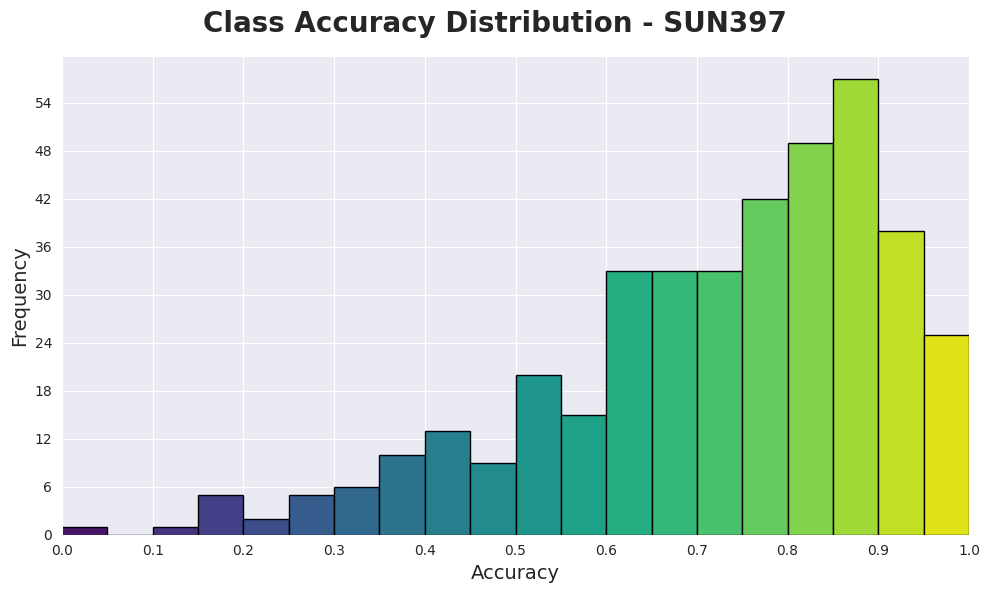

In [59]:
plot_per_class_accuracies(
    sun397_per_class_acc,
    'SUN397',
    num_bins=20
)

#### DTD

In [60]:
vit_dtd = Backbone(model_names['ViT'], num_classes=len(dtd_train.get_labels()))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([47]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([47, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
get_model_params(vit_dtd)

Parameters: 85.83M


In [62]:
dtd_loss, dtd_acc, dtd_per_class_acc = train_model(
    vit_dtd,
    dtd_train,
    config,
    'vit',
    use_val=False,
    fine_tune=True,
)

100%|██████████| 470/470 [00:48<00:00,  9.61it/s]


Epochs: 1/10 | train_loss: 2.6975 | train_acc: 0.4186


100%|██████████| 470/470 [00:46<00:00, 10.07it/s]


Epochs: 2/10 | train_loss: 0.9474 | train_acc: 0.8295


100%|██████████| 470/470 [00:47<00:00, 10.00it/s]


Epochs: 3/10 | train_loss: 0.3699 | train_acc: 0.9465


100%|██████████| 470/470 [00:46<00:00, 10.09it/s]


Epochs: 4/10 | train_loss: 0.1447 | train_acc: 0.9910


100%|██████████| 470/470 [00:46<00:00, 10.12it/s]


Epochs: 5/10 | train_loss: 0.0614 | train_acc: 0.9984


100%|██████████| 470/470 [00:47<00:00,  9.92it/s]


Epochs: 6/10 | train_loss: 0.0307 | train_acc: 0.9995


100%|██████████| 470/470 [00:49<00:00,  9.42it/s]


Epochs: 7/10 | train_loss: 0.0264 | train_acc: 0.9979


100%|██████████| 470/470 [00:47<00:00,  9.85it/s]


Epochs: 8/10 | train_loss: 0.0158 | train_acc: 0.9992


100%|██████████| 470/470 [00:47<00:00,  9.96it/s]


Epochs: 9/10 | train_loss: 0.0090 | train_acc: 1.0000


100%|██████████| 470/470 [00:47<00:00,  9.83it/s]

Epochs: 10/10 | train_loss: 0.0059 | train_acc: 1.0000


In [63]:
dtd_loss, dtd_acc, dtd_per_class_acc = evaluate_model(
    vit_dtd,
    dtd_test,
    config
)

100%|██████████| 235/235 [00:11<00:00, 20.77it/s]

test_loss: 0.8293 | test_acc: 0.7888


In [64]:
dtd_accs.append(dtd_acc)

In [65]:
get_top_5_accuracies(dtd_per_class_acc)

[('chequered', 0.975),
 ('cobwebbed', 0.975),
 ('crystalline', 0.975),
 ('knitted', 0.95),
 ('studded', 0.95)]

In [66]:
get_bottom_5_accuracies(dtd_per_class_acc)

[('blotchy', 0.4),
 ('stained', 0.425),
 ('woven', 0.425),
 ('pitted', 0.575),
 ('bumpy', 0.6)]

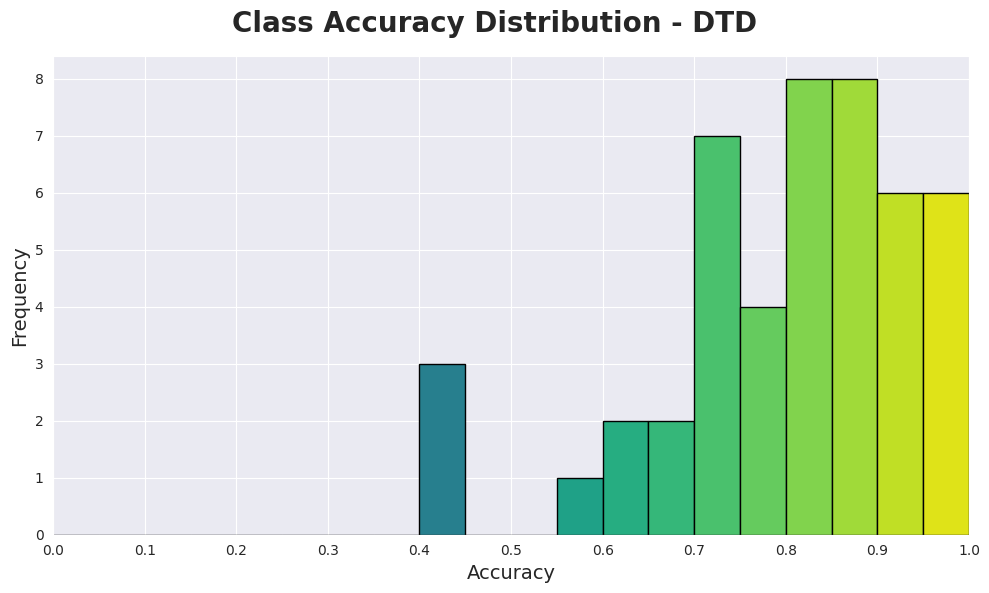

In [67]:
plot_per_class_accuracies(
    dtd_per_class_acc,
    'DTD',
    num_bins=20
)

### Results

Display the results of the analysis in dataframe.

In [68]:
results = [
    resisc45_accs,
    food101_accs,
    fer2013_accs,
    pcam_accs,
    sun397_accs,
    dtd_accs,
]

In [69]:
labels = ['RESISC45', 'Food-101', 'FER2013', 'PatchCamelyon', 'SUN397', 'DTD']

In [70]:
acc_dict = create_accuracy_dict(
    results,
    labels
)

In [71]:
df = pd.DataFrame(results, columns=['fine-tuning'], index=labels)
df

,fine-tuning
RESISC45,0.946032
Food-101,0.877861
FER2013,0.697687
PatchCamelyon,0.888702
SUN397,0.763540
DTD,0.788830
